# The Advantage of Being Small - A Model For Individual Investors

## Introduction

Equity markets consist of some of the most studied data in the world. With millions invested annually into research and computational tools beyond what's accessible to the average individual, it's not hard to see that an individual investor doing their own analysis will have a tough time outperforming. Currently, I see two paths to success:

1. **Find a strategy the institutions haven't:** while possible, this is somewhat unlikely, considering the disparity in resources spent on the problem. You'd have to be incredibly lucky, and even still, it's probably only a matter of time before an institution catches on, at which point any alpha is lost.


2. **Find a strategy that institutions can't implement:** while the large amount of resources gives institutions ample opportunity, they also impose limitations. In particular, investing large amounts of capital has an impact on the market by moving equity prices and, as a result, signalling the rest of the market. This effect is especially pronounced in smaller caps. Moving large blocks of stock can be difficult and imprecise. 

The second point presents an opportunity and is the basis for this project. 

Imagine a stock with a 500m market cap that has been choppy for the past two years, moving cyclically between \\$4.50 and \\$5.50. A large institution sets a buy price at \\$5.00 and sell at \\$5.10, hoping to lock in a 2\% gain on every trade. Putting in an order to buy 100k shares at \\$5.00 will likely settle in blocks. Depending on the liquidity of the stock, executing such a large order will push up the stock price. In all likelihood, some blocks will settle at \\$5.00, some at \\$5.01... etc. Selling those 100k shares will have the opposite effect, pushing down the price during execution of the order. The result is far from the 2\% expected return (possibly even negative, depending on how much the order moves the stock price). Buying 100 shares, however, will likely settle in a single block and thus face no such issues. 

### Methodology

This project will follow the following framework:

1. Retrieve stock price data from the web using the yfinance package.


2. Design functions to:

    a) Filter stocks whose price has stayed within a given range for a given amount of time. 
    
    b) Backtest to find optimal buy and sell price of the given stock for iterative buys/sells within the given window.
    
    c) Calculate future returns given the optimal buy and sell price above.


3. Segment out training data, and fit it to various different machine learning models.

    a) Regression models
    
    b) Classification models
    

4. Evaluate the performance of the best model.


The goal of this project is to find stocks that have been trading within a fixed range for an extended period of time, with the assumption that that will continue. Of course, not all stocks will continue to trade in the same pattern. However, by optimizing filters and implementing a tight stop, my hypothesis is that the success stories can outweigh those that don't. 

Like any other predictive model, overfitting to the training data by tuning the model parameters too specifically to the backtest can easily result in poorer actual returns. In this project, I have aimed to strike a balance between fine-tuning the model and avoiding overfitting, but it remains a concern that needs to be acknowledged.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
#from pandas.tseries.offsets import QuarterEnd

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.ensemble import StackingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import load

pd.set_option('display.float_format', '{:.2f}'.format)

## 1. Retrieve stock price data

To optimize the runtime and avoid unnecessary data downloads, I decided to generate a CSV file containing the price data for all the required tickers. Since I had to access data from the same tickers repeatedly, using a CSV file ensured data consistency and eliminated any concerns about discrepancies caused by downloading data multiple times.

Separate CSVs were created for closing, high, and low prices. 

In [2]:
#create CSVs to store price data as opposed to downloading it throughout (much faster since I will be accessing
#.  data from the same tickers repeatedly)
start_date = datetime.date(2018,1,1)
end_date = datetime.date.today()

tickers = pd.read_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                      'Equity-market-analysis/tickers.csv')
tickers = tickers.rename(columns = {"A": "Ticker"})
tickers = tickers["Ticker"]

In [ ]:
#create CSVs 
closing_price_data = pd.DataFrame()
high_price_data = pd.DataFrame()
low_price_data = pd.DataFrame()

downloaded_tickers = []

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d", progress=False)
        
    closing_price_data = pd.concat([closing_price_data, data['Close']], axis=1)
    high_price_data = pd.concat([high_price_data, data['High']], axis=1)
    low_price_data = pd.concat([low_price_data, data['Low']], axis=1)
    
closing_price_data.columns = tickers.values
high_price_data.columns = tickers.values
low_price_data.columns = tickers.values

closing_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/closing_price_data.csv', index=True, mode='w')

high_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/high_price_data.csv', index=True, mode='w')

low_price_data.to_csv('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/' + 
                          'Equity-market-analysis/low_price_data.csv', index=True, mode='w')

The closing price data is then cleaned and loaded below. 

In [4]:
#since csv can't store axis, need to reset it

def load_price_csvs(path):
    """
    Load and set index of the given CSV.
    Meant for use on closing, high, and low price data files.
    """

    price_data = pd.read_csv(path)
    price_data = price_data.set_index("Unnamed: 0")
    price_data = price_data.rename_axis("Date")
    
    return price_data

high_price_data = load_price_csvs('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/Equity-ma' \
                      'rket-analysis/high_price_data.csv')

low_price_data = load_price_csvs('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/Equity-ma' \
                      'rket-analysis/low_price_data.csv')

closing_price_data = load_price_csvs('/Users/kaigroden-gilchrist/Downloads/Personal_Project/SuccessiveSmallGains/Equity-ma' \
                      'rket-analysis/closing_price_data.csv')

Given my hypothesis that this strategy would perform better on smaller market cap stocks, I divided the price data into three groups based on market cap: small, mid, and large. This project only assesses performance against small-cap stocks (market cap < 2-billion).

It is important to note that this is the present-day market cap (June 2023). Ideally, I would scrape for historical data, but this is a good place to start. 

In [5]:
market_cap_dict = {}

for ticker in tickers:
    try:
        mcap = yf.Ticker(ticker).fast_info['marketCap']
        market_cap_dict.update({ticker:mcap})
    except: KeyError #ignore tickers with no market cap available

In [6]:
# create dicts of tickers for each market cap
small_caps_dict = {k: v for k, v in market_cap_dict.items() if v < 2_000_000_000}
mid_caps_dict = {k: v for k, v in market_cap_dict.items() if 2_000_000_000 <= v <= 10_000_000_000}
large_caps_dict = {k: v for k, v in market_cap_dict.items() if v > 10_000_000_000}

# retrieve the tickers (keys) for each dict
small_cap_tickers = small_caps_dict.keys()
mid_cap_tickers = mid_caps_dict.keys()
large_cap_tickers = large_caps_dict.keys()

# filter the original price data for only the tickers with that market cap
small_cap_price_data = closing_price_data[small_cap_tickers]
mid_cap_price_data = closing_price_data[mid_cap_tickers]
large_cap_price_data = closing_price_data[large_cap_tickers]

In [7]:
small_cap_price_data

,AAC,AAN,AAT,AC,ACCO,ACEL,ACHR,ACRE,ACRO,ADCT,...,XPDB,XPEL,XRX,YORW,ZEUS,ZFOX,ZNTL,ZUMZ,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,NaN,NaN,38.16,33.98,12.50,9.73,NaN,12.79,NaN,NaN,...,NaN,NaN,29.37,33.35,22.28,NaN,NaN,20.00,7.93,3.01
2018-01-03 00:00:00,NaN,NaN,37.82,34.03,12.15,9.73,NaN,12.55,NaN,NaN,...,NaN,NaN,29.33,32.60,22.92,NaN,NaN,20.50,7.97,3.00
2018-01-04 00:00:00,NaN,NaN,37.12,34.13,12.30,9.73,NaN,12.55,NaN,NaN,...,NaN,NaN,29.69,32.50,22.64,NaN,NaN,22.95,8.43,2.95
2018-01-05 00:00:00,NaN,NaN,37.14,33.98,12.35,9.75,NaN,12.59,NaN,NaN,...,NaN,NaN,29.91,32.75,22.28,NaN,NaN,22.55,8.40,2.86
2018-01-08 00:00:00,NaN,NaN,37.22,33.93,12.40,9.70,NaN,12.55,NaN,NaN,...,NaN,NaN,30.26,32.95,22.86,NaN,NaN,23.00,8.31,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13 00:00:00,NaN,7.26,18.48,32.81,4.73,10.64,5.20,9.50,10.31,0.50,...,10.67,45.35,13.23,36.41,51.82,0.61,10.26,15.73,7.27,8.86
2023-11-14 00:00:00,NaN,8.45,19.98,33.33,5.00,11.07,5.98,10.09,10.30,0.55,...,10.67,47.44,13.77,38.82,54.31,0.63,11.74,17.71,7.63,9.25
2023-11-15 00:00:00,NaN,8.80,19.91,33.52,5.19,10.84,6.45,10.25,10.30,0.58,...,10.67,47.05,13.77,38.22,55.72,0.68,11.72,18.76,7.71,8.82


## 2. Design functions

### 2a. Filter stocks

The first function needs to filter stocks to keep only those with minimal variability (since the hypothesis is that stocks which have been trading relatively flat/choppy will continue to do so). It does so by ensuring the price stays within a specified range of the mean within the given window.  

In [8]:
def min_var_filter(price_data, model_start_date, var=0.1, period=200):
    
    """
    Return dict of {tickers:price adjusted stdev} for stocks whose price stays within var% of of the mean price
        in period days prior to the model_start_days.
        
    If max/min price too high/low set var to -1.
    Else find var to make sure price isn't TOO stable.

    """
    # set date range
    start_date = str(model_start_date - datetime.timedelta(period))
    end_date = str(model_start_date)
    
    # retrieve data and drop nan
    stock_data = closing_price_data.loc[start_date:end_date]
    nan_cols = stock_data.columns[stock_data.iloc[0].isna()]
    stock_data = stock_data.drop(columns=nan_cols)
    
    var_dict = {}

    def calc_var(closing_price_data, column):
        """
        If the given ticker's max and min price is within var% of the mean, return it and the price adjusted
            deviation. 
        Else return the ticker and -1. 
        """
        ticker = column.name

        avg_close = np.mean(closing_price_data)
        max_close = np.max(closing_price_data)
        min_close = np.min(closing_price_data)

        upper_bound = (1+var)*avg_close
        lower_bound = (1-var)*avg_close

        # check prices
        # if price stays within bounds, calculate variability
        if (max_close > upper_bound) or (min_close < lower_bound):
            pv = -1
        else:         
            closing_std_dev = np.std(closing_price_data) 
            pv = closing_std_dev / avg_close #price adjusted deviation

        return (ticker, pv)

    # use dictionary comprehension to filter out negative values
    var_dict = {key: val for key, val in [calc_var(stock_data[col_name], stock_data[col_name]) 
                                          for col_name in stock_data.columns] if val >= 0}

    return var_dict


### 2b. Backtest to find optimal buy and sell price

For each stock found above, we'll do a backtest to find the buy and sell prices that maximize returns over the given period. 

In [62]:
def back_calculate_returns(list_of_stocks, start_date, end_date):
    """
    Find and print the optimal buy and sell price of each stock in the given list over the given range
    Also gives total % returns over that period.
    
    Initially tried vectorized buy and sell functions, but actually increased runtime so reverted to for-loops.
    """
    
    def retrieve_stock_data(stock, start_date, end_date):
        """Return high and low price data for the given stock in the given date range"""
        high_data = high_price_data.loc[start_date:end_date][stock].round(2)
        low_data = low_price_data.loc[start_date:end_date][stock].round(2)
        
        stock_data = pd.concat([high_data, low_data], axis=1)
        stock_data.columns = ["High", "Low"]
        
        return stock_data
    
    def init(stock_data):
        min_low = np.min(stock_data["Low"])
        max_high = np.max(stock_data["High"])
        increment = (min_low / 100) + 0.01
  
        return min_low, max_high, increment
        
    
    def find_best_buy_sell(stock_data, min_low, max_high, increment, 
                           owned=False, max_profit=0, best_buy=0, best_sell=0):
        """
        Find the best buy and sell prices for a given stock using the given price data and price range
        """
        buy_prices = np.arange(min_low, max_high, increment)

        for buy_price in buy_prices:
            sell_prices = np.arange(buy_price, max_high, increment)

            for sell_price in sell_prices:
                profit = 0.
                owned = False

                for index, row in stock_data.iterrows():
                    if owned:
                        if (row["High"] >= sell_price):
                            profit += (sell_price - buy_price)
                            owned = False
                    else:
                        if (row["Low"] <= buy_price):
                            owned = True

                if (profit > max_profit):
                    max_profit = round(profit, 2)
                    best_sell = round(sell_price, 2)
                    best_buy = round(buy_price, 2)

        return max_profit, best_sell, best_buy
             
    returns = {}
    
    for stock in list_of_stocks:
        stock_data = retrieve_stock_data(stock, start_date, end_date)
        min_low, max_high, increment = init(stock_data)
        max_profit, best_sell, best_buy = find_best_buy_sell(stock_data, min_low, max_high, increment)
        percent_return = max_profit / best_buy * 100 if best_buy != 0 else 0
        num_buys_sells = round(max_profit / (best_sell - best_buy)) if best_buy != 0 else 0

        returns.update({stock : {"buy_price" : best_buy, "sell_price" : best_sell, 
                "min_low" : min_low, "max_high" : max_high, 'backtest_returns' : percent_return, 
                       'num_buys_sells' : num_buys_sells}})

    
    return returns


### 2c. Calculate future returns

Lastly, we need a function that uses the optimal buy and sell prices above to simulate this strategy over the given interval. 

In [63]:
def front_calculate_returns(dict_of_stocks, start_date, end_date):
    """
    Calculate returns over given interval for each stock using buy/sell prices within the given dict. 
    
    Sell out if price goes below min low (also within the given dict).
    """
    
    def retrieve_stock_data(stock, start_date, end_date):
        """Return high and low price data for the given stock in the given date range"""
        high_data = high_price_data.loc[start_date:end_date][stock].round(2)
        low_data = low_price_data.loc[start_date:end_date][stock].round(2)
        
        stock_data = pd.concat([high_data, low_data], axis=1)
        stock_data.columns = ["High", "Low"]
        
        return stock_data
    
    def calculate_returns(stock_data, buy_price, sell_price, min_low):
        owned = False
        profit = 0.

        for index, row in stock_data.iterrows():
            # break if you leave the lower bound of the backtest data
            if (row["Low"] < min_low):
                if (owned):
                    profit += row["Low"]
                return profit
            elif (owned):
                if (row["High"] >= sell_price):
                    profit += sell_price
                    owned = False
            elif (not owned):
                if (row["Low"] <= buy_price):
                    profit -= row["Low"]
                    owned = True
                    
        if (owned): # sell at the low price (to be conservative) on end date if still owned
            profit += stock_data.iloc[-1]["Low"]
            owned = False
        return profit

    
    fwd_returns_dict = {}  

    for ticker in dict_of_stocks:
        
        prices = dict_of_stocks[ticker]
        buy_price = prices["buy_price"]
        sell_price = prices["sell_price"]
        min_low = prices["min_low"]
        max_high = prices["max_high"]
        
        stock_data = retrieve_stock_data(ticker, start_date, end_date)
        stock_data = stock_data.round(2)
        
        profit = calculate_returns(stock_data, buy_price, sell_price, min_low)

        try:
            percent_return = profit / buy_price * 100
        except ZeroDivisionError:
            percent_return = 0
        
        fwd_returns_dict.update({ticker:percent_return})
        
    return fwd_returns_dict

The accuracy of each function was manually verified against the price data for randomly selected samples. 

### 2d. Combining into a single function

Now I'll combine each helper function into one master function, and use it on the small cap price data.

In [64]:
def list_of_returns_calc(price_data, var, dates, back_days, front_days):
    
    """
    Uses the given price data to:
        1. Filter stocks which kept within var percent of their mean price over the back_days backtest period.
        2. On each filtered stock, performs the backtest using the back_calculate_returns function defined in 
            2.b. 
        3. Retrieve price data for each backtest period, normalized as a percent return from the start date.
        4. Uses the backtest output to calculate forward returns using the front_calculate_returns function 
            defined in 2.c. 
    Returns the output of each of the above as a separate dataframe for ease of validation/processing downstream.
    """
    
    var_ret = pd.DataFrame()
    back_ret = pd.DataFrame()
    price_movement = pd.DataFrame()
    fwd_ret = pd.DataFrame()
    
    for date in dates:
        extracted_date = datetime.datetime.strptime(date, '%Y-%m-%d')
        model_start_date = datetime.date(extracted_date.year, extracted_date.month, extracted_date.day)
        
        var_dict = min_var_filter(price_data, var=var, model_start_date=model_start_date, period=back_days)
        ticker_list = list(var_dict.keys())
        var_ret = pd.concat([var_ret, pd.DataFrame.from_dict(var_dict, orient='index', columns=['Var']).T], axis=1)
        
        back_start_date = str(model_start_date - datetime.timedelta(back_days))
        back_end_date = str(model_start_date)
        back_returns = back_calculate_returns(ticker_list, back_start_date, back_end_date)
        back_ret = pd.concat([back_ret, pd.DataFrame(back_returns)],axis=1)
        
        temp = closing_price_data.loc[back_start_date:back_end_date, ticker_list].apply(
                 lambda x: x.div(x.iloc[0]).subtract(1).mul(100)).T
        temp.columns = np.arange(1, len(temp.columns) + 1)
        price_movement = pd.concat([price_movement, temp.T], axis=1)

        fwd_start_date = str(model_start_date) 
        fwd_end_date = str(model_start_date + datetime.timedelta(front_days))
        fwd_returns = front_calculate_returns(back_returns, fwd_start_date, fwd_end_date)
        fwd_ret = pd.concat([fwd_ret, pd.DataFrame.from_dict(fwd_returns, orient='index', columns=['Fwd rets']).T], axis=1)
        
    return var_ret, back_ret, fwd_ret, price_movement

In [65]:
test_dates = pd.period_range(start='2018-12-31', end='2022-12-31', freq='Q').strftime('%Y-%m-%d').tolist()

var_df, back_df, fwd_df, price_df = list_of_returns_calc(small_cap_price_data, 0.1, test_dates, 150, 90)

In [66]:
combined_df = pd.concat([var_df.T, back_df.T], axis=1)
combined_df = pd.concat([combined_df, fwd_df.T], axis=1)
combined_df = pd.concat([combined_df, price_df.T], axis=1)
combined_df.head()

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,Fwd rets,1,2,...,96,97,98,99,100,101,102,103,104,105
ABT,0.04,68.84,72.04,63.07,74.92,27.92,6.00,9.50,0.00,0.02,...,5.78,4.83,3.13,0.51,6.73,8.28,8.98,NaN,NaN,NaN
ACEL,0.00,9.84,10.38,9.84,10.40,5.49,1.00,0.00,0.00,-0.20,...,-2.16,-2.16,-1.96,-1.96,-1.57,-1.96,-1.96,NaN,NaN,NaN
ACRE,0.03,13.85,14.67,12.75,14.77,11.91,2.00,13.29,0.00,0.64,...,-3.06,-6.70,-5.77,-8.27,-4.92,-7.20,-6.70,NaN,NaN,NaN
AEE,0.03,63.55,66.04,61.07,70.95,15.63,4.00,4.58,0.00,0.19,...,7.62,7.33,7.19,1.27,3.04,4.56,3.99,NaN,NaN,NaN
AFB,0.02,11.91,12.04,11.78,12.69,3.19,3.00,0.00,0.00,-0.32,...,-5.08,-5.24,-4.85,-4.21,-5.24,-5.16,-4.92,NaN,NaN,NaN


## 3. ML Models

### 3a. Feature selection and engineering

From a domain analysis perspective, some of these features are unlikely to be relevant. 

The buy_price, sell_price, min_low, and max_high are related to the price of the stock. Since I'm not expecting the price level to influence whether this strategy will work or not, those can be dropped. 

I think it may also be relevant to add the mean and median prices as features. 

I also worry that the number of price columns is too high. We may be missing the forest through the trees by using every single date's price. Rather, it may make sense to only keep the price for every 10 trading days. 

One observation is missing price data for the 11th day. I'm just going to drop that observation as opposed to using an imputer.

In [67]:
price_cols = combined_df.loc[:,1:105]

# add mean price feature
mean_prices = price_cols.mean(axis=1)
combined_df['mean_price'] = mean_prices

# add median price feature
median_prices = price_cols.median(axis=1)
combined_df['median_price'] = median_prices

# drop cols not multiples of 10
keep_cols = np.arange(1,106,10)
all_cols = np.arange(1,106)
drop_cols = np.setdiff1d(all_cols, keep_cols)
combined_df = combined_df.drop(columns=drop_cols)
combined_df.head()

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,Fwd rets,1,11,...,31,41,51,61,71,81,91,101,mean_price,median_price
ABT,0.04,68.84,72.04,63.07,74.92,27.92,6.00,9.50,0.00,-0.78,...,3.74,13.63,5.32,3.19,8.17,6.87,11.19,8.28,5.70,5.57
ACEL,0.00,9.84,10.38,9.84,10.40,5.49,1.00,0.00,0.00,-1.37,...,-1.18,-1.27,-0.69,-0.98,-1.76,-1.96,-1.96,-1.96,-1.45,-1.47
ACRE,0.03,13.85,14.67,12.75,14.77,11.91,2.00,13.29,0.00,0.71,...,2.71,-1.64,-1.64,-0.71,3.64,1.14,1.00,-7.20,0.49,0.71
AEE,0.03,63.55,66.04,61.07,70.95,15.63,4.00,4.58,0.00,3.70,...,4.47,1.35,2.19,4.40,9.51,9.98,11.83,4.56,5.06,4.19
AFB,0.02,11.91,12.04,11.78,12.69,3.19,3.00,0.00,0.00,-0.16,...,-1.99,-1.59,-5.16,-4.61,-4.69,-5.48,-4.05,-5.16,-3.24,-4.13


In [68]:
combined_df.columns = combined_df.columns.astype(str)
combined_df.dropna(axis=0, inplace=True)
combined_df.describe()

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,Fwd rets,1,11,...,31,41,51,61,71,81,91,101,mean_price,median_price
count,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,...,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00,7846.00
mean,0.03,405.48,443.58,397.58,459.02,17.88,3.32,0.42,0.00,0.93,...,0.93,0.57,1.29,1.46,1.82,1.60,2.00,1.86,1.19,1.18
std,0.01,10953.05,12021.30,10786.63,12403.26,9.52,2.86,5.02,0.00,3.45,...,4.86,4.92,5.38,5.69,5.91,6.29,6.06,6.48,4.19,4.25
min,0.00,0.00,0.00,1.64,1.95,0.00,0.00,-44.08,0.00,-12.86,...,-15.30,-15.46,-15.58,-16.69,-16.67,-17.77,-16.85,-16.25,-9.08,-11.10
25%,0.02,13.46,14.53,13.20,14.89,11.62,1.00,-0.30,0.00,-0.91,...,-2.00,-2.52,-1.99,-2.18,-1.87,-2.33,-2.00,-2.42,-1.67,-1.58
50%,0.03,28.58,31.00,27.38,32.44,17.72,2.00,0.00,0.00,0.59,...,0.59,0.37,1.00,1.16,1.42,1.47,1.61,1.47,0.90,0.84
75%,0.04,66.15,71.78,62.87,74.48,23.26,4.00,0.00,0.00,2.84,...,4.01,3.70,4.74,5.19,5.91,5.83,6.11,6.17,4.09,4.04
max,0.07,417180.02,479474.86,409000.00,483393.00,163.10,24.00,78.19,0.00,17.37,...,19.74,18.83,18.97,20.37,20.05,20.83,20.02,21.45,11.11,13.51


Data will need to be scaled, but aside from that it looks good. Let's take a look at the final training set. 

In [69]:
train_df, test_df = train_test_split(combined_df, test_size=0.25, random_state=123)
X_train, y_train, X_test, y_test = (
    train_df.drop(columns=["Fwd rets"]),
    train_df["Fwd rets"],
    test_df.drop(columns=["Fwd rets"]),
    test_df["Fwd rets"]
)
X_train.head()

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,1,11,21,31,41,51,61,71,81,91,101,mean_price,median_price
HUBB,0.05,199.56,208.51,178.07,212.54,17.94,4.00,0.00,1.20,2.41,-4.92,-8.16,-9.54,-5.26,3.38,3.60,3.14,1.56,-1.35,0.38
NRC,0.05,61.58,64.35,54.38,68.17,22.49,5.00,0.00,3.04,2.53,0.14,-10.02,-8.12,-8.56,-1.92,1.17,2.19,7.68,-1.15,0.14
BELFA,0.05,13.56,14.70,13.14,16.19,33.33,4.00,0.00,-2.25,1.16,-6.43,-6.17,-14.73,-14.79,-1.09,-9.32,-10.55,-8.75,-5.65,-6.17
BCSF,0.02,15.38,15.85,14.75,16.29,24.58,8.00,0.00,-0.77,-2.30,-1.09,0.83,1.22,0.06,2.56,0.96,-0.19,2.11,0.38,0.32
CHI,0.02,10.08,10.51,9.76,10.79,8.53,2.00,0.00,-0.48,-1.07,-1.94,-1.55,0.78,2.81,-0.29,-2.23,0.19,0.58,0.04,-0.05


### 3b. Regression models

Since the target (fwd_returns) is numerical, I initially tried to model this as a regression problem. However, I was unable to find a model with much success, so decided to reframe this as a classification problem instead. 

These models are all having very little success. Perhaps we can do better by pivoting, and treating this as a classification problem instead.

### 3c. Classification models

Assessing this as a classification problem gives a few options. The approach I am taking is as follows:

- Look to predict stocks with positive forward returns with high precision (of the stocks predicted, most need to be correct), treating anything else as the negative class.

We can start by transforming our target column to represent the binary classification. 

In [70]:
y_train_class = pd.Series(np.where(y_train > 0, 1, 0))
y_test_class = pd.Series(np.where(y_test > 0, 1, 0))
y_train_class

0       0
1       0
2       0
3       0
4       0
       ..
5879    0
5880    0
5881    1
5882    0
5883    1
Length: 5884, dtype: int64

We'll start again with the Dummy model to get a baseline. 

In [ ]:
class_results = {}

dummy_class = DummyClassifier()

class_results['Dummy'] = pd.DataFrame(cross_validate(dummy_class, X_train, y_train_class, cv=5, return_train_score=True, scoring='precision')).mean()

pd.DataFrame(class_results).T

DummyClassifier has a precision of 0 (because it never predicts positive), reflecting the class imbalance in the dataset.

Let's see if we can improve on that. 

We'll start with a LogisticRegression model. 


In [ ]:
Cs = 10.0 ** np.arange(-5, 6, 1)
scaler = StandardScaler()
train_scores = []
cv_scores = []
for c in Cs:
    pipe = make_pipeline(scaler, LogisticRegression(C=c, max_iter = 2000))
    res = cross_validate(pipe, X_train, y_train_class, return_train_score=True, scoring='precision')
    train_scores.append(np.mean(res["train_score"]))
    cv_scores.append(np.mean(res["test_score"]))

0.001


Text(0, 0.5, 'score')

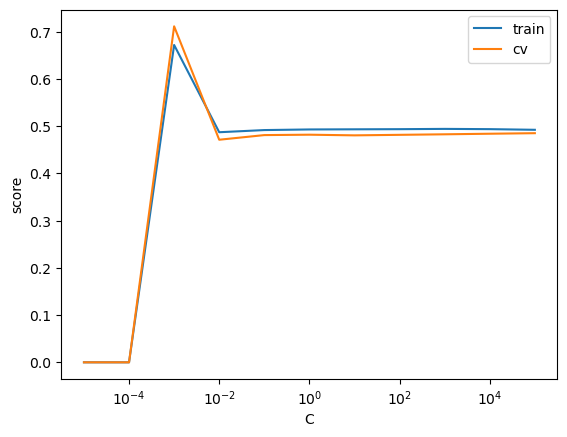

In [73]:
best_C = Cs[np.argmax(cv_scores)]    
print(best_C)
    
plt.semilogx(Cs, train_scores, label="train")
plt.semilogx(Cs, cv_scores, label="cv")
plt.legend()
plt.xlabel("C")
plt.ylabel("score")

Lower values of C are giving a less complex model, and so end up predicting postive returns less often. 

0.001 is the best C value amongst those tried.

In [74]:
best_logreg_pipe = make_pipeline(scaler, LogisticRegression(C=best_C, max_iter=2000))
class_results['LogisticRegression'] = pd.DataFrame(cross_validate(best_logreg_pipe, X_train, y_train_class, cv=5, 
                                                                  return_train_score=True, scoring='precision')
                                                  ).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67


65% precision, but is an excellent start. If it translates to the testing data, we'll at least be hitting on over 50% of our predictions (money weighted returns will need to be addressed later).

In [75]:
best_logreg_pipe.fit(X_train, y_train_class)
pd.Series(best_logreg_pipe.predict(X_train)).value_counts()

0    5822
1      62
dtype: int64

My worry was that the model was getting this 65% precision with only a few predictions (and so I'd be less confident in the resulting percentage), but 74 is not bad. 

Next, we can try a tree classifier. 

In [ ]:
depths = np.arange(1,20)
train_scores = []
cv_scores = []
for depth in depths:
    dtc = DecisionTreeClassifier(max_depth=depth)
    res = cross_validate(dtc, X_train, y_train_class, return_train_score=True, scoring='precision')
    train_scores.append(np.mean(res["train_score"]))
    cv_scores.append(np.mean(res["test_score"]))

5


Text(0, 0.5, 'score')

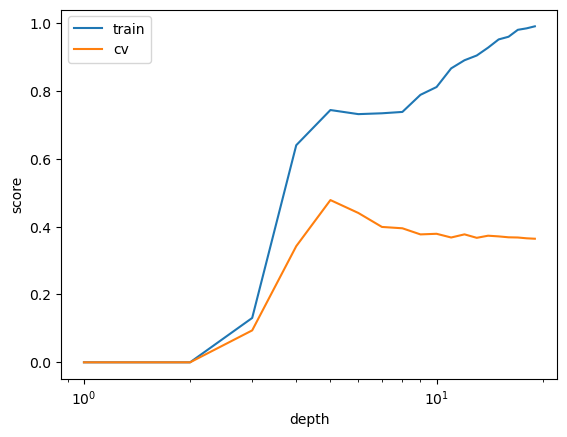

In [77]:
best_depth = depths[np.argmax(cv_scores)]    
print(best_depth)
    
plt.semilogx(depths, train_scores, label="train")
plt.semilogx(depths, cv_scores, label="cv")
plt.legend()
plt.xlabel("depth")
plt.ylabel("score")

In [78]:
optimal_dtr_class = DecisionTreeClassifier(max_depth=best_depth)
class_results['DecisionTree'] = pd.DataFrame(cross_validate(optimal_dtr_class, X_train, y_train_class, cv=5, 
                                                            return_train_score=True, scoring='precision')).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67
DecisionTree,0.05,0.00,0.47,0.74


It's not too surprising that the DecisionTreeClassifier would be worse that the LR. It was done more as a baseline for the ensemble models that follow.

In [ ]:
param_grid = {
    'max_depth': np.arange(1,20,2),
    'max_features': ['sqrt', 'log2', None, 1]
}

rfc = RandomForestClassifier(n_estimators=1000, random_state=123, n_jobs=-1)

grid_search = GridSearchCV(
    rfc, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring='precision'
)
grid_search.fit(X_train, y_train_class)
best_depth = grid_search.best_params_['max_depth']
best_max_features = grid_search.best_params_['max_features']

In [80]:
print(f"The best depth is: {best_depth} \nThe best number of features is: {best_max_features}")

The best depth is: 15 
The best number of features is: 1


In [81]:
rfc_best = RandomForestClassifier(max_depth=best_depth, max_features=best_max_features, 
                                  n_estimators=1000, random_state=123, n_jobs=-1)
class_results['RandomForest'] = pd.DataFrame(
    cross_validate(rfc_best, X_train, y_train_class, cv=5, return_train_score=True, scoring='precision')).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67
DecisionTree,0.05,0.00,0.47,0.74
RandomForest,2.11,0.27,0.77,1.00


78% is an improvement! It's definitely overfit though. It would be best to lower the depth slightly. 

In [ ]:
rfc_best = RandomForestClassifier(max_depth=5, max_features=best_max_features, 
                                  n_estimators=1000, random_state=123, n_jobs=-1)
class_results['RandomForest (not overfit)'] = pd.DataFrame(
    cross_validate(rfc_best, X_train, y_train_class, cv=5, return_train_score=True, scoring='precision')).mean()
pd.DataFrame(class_results).T

The highest depth I can get without overfitting is 5, at which point the model is doing... horribly. 

A gradient boosting model may do better.

In [ ]:
param_grid = {
    'max_depth': np.arange(1,30,1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
    'num_leaves': np.arange(2,20,1),
    'feature_fraction': np.arange(0.1,1.1,0.1)
}

lgbmc = LGBMClassifier(n_estimators=1000, random_state=123, colsample_bytree=None)

random_search = RandomizedSearchCV(
    lgbmc, param_grid, n_iter=1000, cv=5, n_jobs=-1, return_train_score=True, scoring='precision'
)
random_search.fit(X_train, y_train_class)
best_depth = random_search.best_params_['max_depth']
best_lr = random_search.best_params_['learning_rate']
best_num_leaves = random_search.best_params_['num_leaves']
best_ff = random_search.best_params_['feature_fraction']
best_depth, best_lr, best_num_leaves, best_ff

In [84]:
print(f"The best depth is: {best_depth} \nThe best number of features is: {best_max_features} \n" + 
     f"The best number of leaves is: {best_num_leaves} \nThe best fraction of features is: {best_ff}")

The best depth is: 13 
The best number of features is: 1 
The best number of leaves is: 6 
The best fraction of features is: 0.2


In [85]:
lgbmc_best = LGBMClassifier(max_depth=best_depth, learning_rate=best_lr, 
                          num_leaves=best_num_leaves, feature_fraction=best_ff,
                          n_estimators=1000, random_state=123, colsample_bytree=None)
class_results['LGBM'] = pd.DataFrame(
    cross_validate(lgbmc_best, X_train, y_train_class, cv=5, return_train_score=True,
                  scoring='precision')).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67
DecisionTree,0.05,0.00,0.47,0.74
RandomForest,2.11,0.27,0.77,1.00
RandomForest (not overfit),1.38,0.25,0.00,0.00
LGBM,1.12,0.02,0.63,0.86


Unexpectedly, the LGBMClassifier was worse than the RandomForest, although it is (a bit) less overfit. 

Try manually adjusting hyperparameters again to reduce overfitting.

In [86]:
lgbmc_best = LGBMClassifier(max_depth=3, learning_rate=0.01, num_leaves=3,
                          n_estimators=1000, random_state=123)
class_results['LGBM (not overfit)'] = pd.DataFrame(
    cross_validate(lgbmc_best, X_train, y_train_class, cv=5, return_train_score=True,
                  scoring='precision')).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67
DecisionTree,0.05,0.00,0.47,0.74
RandomForest,2.11,0.27,0.77,1.00
RandomForest (not overfit),1.38,0.25,0.00,0.00
LGBM,1.12,0.02,0.63,0.86
LGBM (not overfit),0.67,0.02,0.56,0.71


That seems a bit better, but it's still overfit.

How about an SVC?

In [ ]:
param_grid = {
    "svc__gamma": 10.0 ** np.arange(-3, 3, 1),
    "svc__C": 10.0 ** np.arange(-3, 3, 1)
}

svc_pipe = make_pipeline(scaler, SVC(random_state=123))

svc_grid = GridSearchCV(
    svc_pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring='precision'
)
svc_grid.fit(X_train, y_train_class)
best_gamma = svc_grid.best_params_['svc__gamma']
best_C = svc_grid.best_params_['svc__C']
best_gamma, best_C

In [88]:
# manually changed gamma from 10 to 1. At 10, no positives were being selected
svc_best_pipe = make_pipeline(scaler, SVC(gamma=best_gamma, C=best_C, random_state=123))
class_results['SVC'] = pd.DataFrame(
    cross_validate(svc_best_pipe, X_train, y_train_class, cv=5, return_train_score=True, scoring='precision')).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67
DecisionTree,0.05,0.00,0.47,0.74
RandomForest,2.11,0.27,0.77,1.00
RandomForest (not overfit),1.38,0.25,0.00,0.00
LGBM,1.12,0.02,0.63,0.86
LGBM (not overfit),0.67,0.02,0.56,0.71
SVC,0.96,0.31,0.83,0.81


Best model yet, but also overfit. We can again tweak the hyperparameters slightly while trying to keep the precision up.

In [89]:
# manually changed gamma from 10 to 1. At 10, no positives were being selected
svc_best_pipe = make_pipeline(scaler, SVC(gamma=0.1, C=1, random_state=123))
class_results['SVC (not overfit)'] = pd.DataFrame(
    cross_validate(svc_best_pipe, X_train, y_train_class, cv=5, return_train_score=True, scoring='precision')).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67
DecisionTree,0.05,0.00,0.47,0.74
RandomForest,2.11,0.27,0.77,1.00
RandomForest (not overfit),1.38,0.25,0.00,0.00
LGBM,1.12,0.02,0.63,0.86
LGBM (not overfit),0.67,0.02,0.56,0.71
SVC,0.96,0.31,0.83,0.81
SVC (not overfit),0.79,0.35,0.58,0.81


Without blatantly overfitting (and the SVC and LGBM models still do), the logistic regression model still looks the best. 

How about a neural network?

In [ ]:
hidden_layers = [(10,10), (50, 50), (100, 100), (200, 200), (10, 10, 10), (100, 100, 100)]

train_scores = []
cv_scores = []

for layer in hidden_layers:
    nn_pipe = make_pipeline(scaler, MLPClassifier(hidden_layer_sizes=layer, random_state=123,
                                                  solver='sgd', learning_rate='adaptive', max_iter=1000))
    res = cross_validate(nn_pipe, X_train, y_train_class, cv=5, return_train_score=True,
                  scoring='precision')
    train_scores.append(np.mean(res["train_score"]))
    cv_scores.append(np.mean(res["test_score"]))
best_layers = hidden_layers[np.argmax(cv_scores)]  

In [91]:
nn_best_pipe = make_pipeline(scaler, MLPClassifier(hidden_layer_sizes=best_layers, random_state=123,
                                                  solver='sgd', learning_rate='adaptive', max_iter=1000))
class_results['Neural Network'] = pd.DataFrame(
    cross_validate(nn_best_pipe, X_train, y_train_class, cv=5, return_train_score=True, scoring='precision')).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67
DecisionTree,0.05,0.00,0.47,0.74
RandomForest,2.11,0.27,0.77,1.00
RandomForest (not overfit),1.38,0.25,0.00,0.00
LGBM,1.12,0.02,0.63,0.86
LGBM (not overfit),0.67,0.02,0.56,0.71
SVC,0.96,0.31,0.83,0.81
SVC (not overfit),0.79,0.35,0.58,0.81
Neural Network,16.62,0.01,0.53,0.65


Surprisingly to me, the neural network has fairly poor performance. It's also by far the most computationally expensive model to run.

In [92]:
classifiers = {
    "logistic_reg": best_logreg_pipe,
    "decision_tree": optimal_dtr_class,
    "svc": svc_best_pipe,
    "lgbmc": lgbmc_best,
    "nn": nn_best_pipe
}

stacking_model = StackingClassifier(list(classifiers.items()))

class_results['Stacking (not overfit)'] = pd.DataFrame(
    cross_validate(stacking_model, X_train, y_train_class, cv=5, return_train_score=True,
                  scoring='precision')).mean()
pd.DataFrame(class_results).T

,fit_time,score_time,test_score,train_score
Dummy,0.00,0.00,0.00,0.00
LogisticRegression,0.01,0.00,0.71,0.67
DecisionTree,0.05,0.00,0.47,0.74
RandomForest,2.11,0.27,0.77,1.00
RandomForest (not overfit),1.38,0.25,0.00,0.00
LGBM,1.12,0.02,0.63,0.86
LGBM (not overfit),0.67,0.02,0.56,0.71
SVC,0.96,0.31,0.83,0.81
SVC (not overfit),0.79,0.35,0.58,0.81
Neural Network,16.62,0.01,0.53,0.65


### 4a. Testing the model

After all that, the logistic regression model boasts the best validation score without being overfit!

Admittedly, more stacking variations could be tried, but sometimes simple is best. 

Perhaps it makes sense that since LR is a probability-based model and we're tuning for high precision, it's easy to select only observations with high probabilities. While other models *may* be able to be tuned more specifically with respect to precision (I did play around with thresholds a bit behind the scenes, to no success), the LR model is doing a very good job. 

It's also worth noting that while 65% precision doesn't *seem* overly impressive, I've included the \$0 forward returns in with the negatives, so it's likely that of the 35\% incorrect, many are 0 and not actually negative. As such, average returns are likely to be positive.

At this point, all that's left to do is validate the model against the test set. 

In [93]:
best_logreg_pipe.fit(X_train, y_train_class)
preds = best_logreg_pipe.predict(X_test)
precision_score(y_test_class, preds)

0.5625

64% precision is right in line with the training and validation scores! This model appears to generalize well. 

In [94]:
pd.Series(preds).value_counts()

0    1946
1      16
dtype: int64

The model identified 25 stocks from the test set (which was 25% of the total dataset - so extrapolate out to ~100 overall). 

Admittedly, I would have liked that number to be higher than 25, if only to increase confidence in that 64% precision. The model would benefit from being tested further on future data.

Lastly, let's take a look at the predicted returns.

In [95]:
predicted_returns = y_test[preds == 1]
predicted_returns.describe()

count   16.00
mean     3.64
std      8.23
min     -8.83
25%     -1.37
50%      1.79
75%      8.66
max     24.22
Name: Fwd rets, dtype: float64

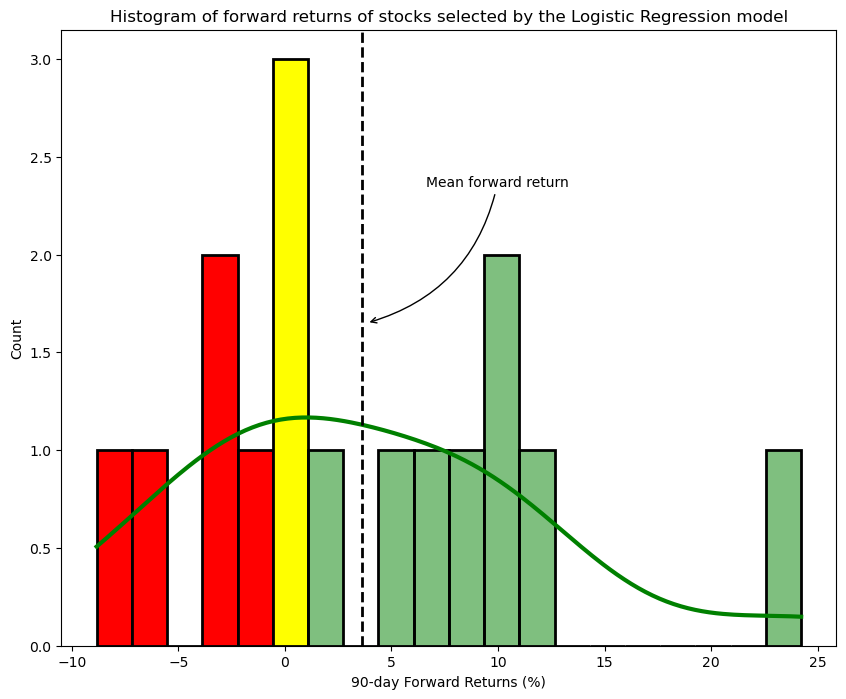

In [96]:
plt.figure(figsize=(10,8))

ax = sns.histplot(predicted_returns, kde=True, bins=20, color='green', linewidth=2, line_kws={'lw': 3})
ax.axvline(predicted_returns.mean(), color='black', linestyle='--', linewidth=2)
ax.annotate(
    'Mean forward return', xy=(predicted_returns.mean()+0.2, ax.get_ylim()[1]-1.5), xytext=(predicted_returns.mean()+3, ax.get_ylim()[1]-1 * 0.8),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3', color='black')
)

for patch in ax.patches:
    if patch.get_x() < 0:
        patch.set_facecolor('yellow')
    if patch.get_x() < -1:
        patch.set_facecolor('red')

ax.set_title('Histogram of forward returns of stocks selected by the Logistic Regression model')
ax.set_xlabel('90-day Forward Returns (%)')

plt.show()

Average returns per stock are **3.64% over a 90-day period**. This equates to a **14.5% annual return**. 

### 4b. Concluding remarks

This sounds too good to be true, and it probably is. I identify the following limitations:
1. Remember that the model is biassed in that it was only given current tickers. This means there was a definite survivor bias within the data. As mentioned before, while I don't expect this to have an extremely significant effect (if I were gathering data all the way back to the 1980s, for example, the survivor bias would be much more significant), it could play a part. 
2. Small-cap stocks were filtered using the present-day market cap. This is unrealistic, as a small cap in 2022 may have been a lot bigger in 2019 when the data was collected. Inversely, a stock that was actually small in 2019 and has since grown does not have its data included here. My expectation is that this may actually bias the model to the downside (I'm essentially missing out on stocks that have grown and been successful), but this assumption is not validated. 
3. The final significant limitation of the model is sample size. While a 2000+ sample test set is not insignificant, only 25 predicted positives leaves questions about my confidence in the model's precision. This model will need to be validated further as time passes and more price data becomes available. 

Moving on to the positives! 
1. This model was able to select some high-upside stocks while avoiding any significant downside. Really, that's every model's dream. With the limitations above in mind, this model's success on the given data is undoubtedly excellent. 
2. The model appears to generalize well, with training, validation, and testing sets all having roughly the same precision scores. 
3. This model was trained over a variety of market environments. This 5-year time period is fairly unique in that there's been a condenced mix of bull and bear market events. This model was tested against data from 2020 and 2022, and managed to avoid any significant downside.

In [97]:
pos_pred_stocks = X_test[preds == 1]
pos_pred_stocks

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,1,11,21,31,41,51,61,71,81,91,101,mean_price,median_price
GRBK,0.03,8.86,9.12,7.96,9.80,51.58,18.00,0.00,4.96,8.27,4.37,3.43,5.91,6.50,5.91,6.03,2.25,-0.24,5.67,5.91
BMRC,0.04,41.90,42.68,38.00,45.13,31.65,17.00,0.00,1.61,2.81,-4.15,-0.42,4.80,1.00,4.59,7.04,1.43,-2.01,0.87,1.34
BCSF,0.02,15.07,15.22,14.60,16.45,13.47,14.00,0.00,-1.62,-0.75,-0.81,-3.56,-3.99,-5.05,-3.87,-5.55,-4.99,-5.30,-3.54,-4.37
ELME,0.02,25.36,25.60,23.18,26.42,20.98,22.00,0.00,3.39,6.62,8.65,6.83,9.03,7.08,9.50,10.14,7.80,7.72,6.98,7.76
NDMO,0.03,17.36,17.52,15.84,17.94,13.59,15.00,0.00,-1.76,2.12,2.00,2.30,5.76,5.52,5.03,4.55,0.36,-2.00,2.18,2.24
EQC,0.02,25.81,26.07,25.03,27.16,14.10,14.00,0.00,1.58,1.42,0.12,0.31,3.62,0.35,-0.15,0.50,-2.43,0.15,0.39,0.19
SHBI,0.02,15.65,15.95,14.00,16.48,30.67,16.00,0.00,3.36,6.91,4.43,0.07,2.82,7.72,5.50,5.23,4.16,5.03,4.02,3.99
TRMK,0.05,30.00,30.60,28.81,34.64,27.83,14.00,0.00,4.64,2.88,-0.64,-5.95,-8.31,-8.86,-4.64,0.94,-7.55,-4.34,-4.21,-5.31
IBTX,0.04,52.44,53.41,47.58,57.67,20.39,11.00,0.00,-7.77,-9.84,-7.22,-3.66,-3.54,-0.76,-11.73,-16.57,-8.54,-7.79,-7.76,-7.49
MFIC,0.04,13.68,13.82,12.35,15.27,20.47,20.00,0.00,0.83,-0.48,2.14,-6.14,-4.55,-4.76,-5.17,-4.83,-5.59,-10.48,-4.04,-4.83


The most obvious thing that stands out here is the num_buy_sells. This variable refers to the number of buys and sells in the backtest, and it's *very* high in all of these predicted positives compared to the mean:

In [98]:
X_test['num_buys_sells'].mean()

3.3103975535168195

And this is confirmed by looking at the coefficients with respect to each feature in the model.

In [99]:
data = {
    "coefficient": best_logreg_pipe.named_steps["logisticregression"].coef_[0].tolist(),
}

feature_names = X_test.columns

coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "coefficient", ascending=False
)
coef_df

,coefficient
num_buys_sells,0.37
backtest_returns,0.07
21,0.07
41,0.04
11,0.03
31,0.03
Var,0.01
buy_price,0.01
min_low,0.01
max_high,0.00


So it was exactly as predicted, the stocks which are choppy within a small range over the course of the backtest more often than not, continue to do so. 

These coefficients also indicate that a price surge towards the end of the backtest period is negatively correlated with future returns, which is not something I would have expected. 

### 5. Update

Since the beginning of this project, two new quarters of data are available. The model can be tested further on these new examples as a sort of mock-deployment. 

In [100]:
update_test_dates = pd.period_range(start='2022-12-31', end='2023-06-30', freq='Q').strftime('%Y-%m-%d').tolist()

update_var_df, update_back_df, update_fwd_df, update_price_df = list_of_returns_calc(
    small_cap_price_data, 0.1, update_test_dates, 150, 90
)

In [101]:
update_combined_df = pd.concat([update_var_df.T, update_back_df.T], axis=1)
update_combined_df = pd.concat([update_combined_df, update_fwd_df.T], axis=1)
update_combined_df = pd.concat([update_combined_df, update_price_df.T], axis=1)
update_combined_df.head()

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,Fwd rets,1,2,...,96,97,98,99,100,101,102,103,104,105
AAC,0.01,9.87,10.09,9.87,10.10,2.23,1.00,0.00,0.00,-0.20,...,1.82,2.02,1.92,1.97,1.92,1.82,2.02,1.92,2.02,1.82
ABT,0.04,97.96,104.56,93.25,112.91,20.20,3.00,1.03,0.00,0.10,...,-2.46,-2.76,-2.85,-1.34,-1.44,-1.30,-0.95,-1.62,0.64,0.16
ACRO,0.01,9.67,9.88,9.67,9.98,2.17,1.00,0.00,0.00,-0.05,...,1.64,1.54,1.54,1.54,1.54,1.75,1.64,1.85,2.26,2.26
AGX,0.05,35.45,37.07,31.26,38.20,27.31,6.00,0.00,0.00,-3.50,...,-2.27,-1.83,-3.31,-0.44,-1.26,-0.33,0.66,-1.48,0.82,0.90
AJG,0.04,174.69,191.58,167.93,201.51,19.34,2.00,7.12,0.00,-0.42,...,5.14,4.43,5.44,6.91,6.09,6.30,6.79,6.04,7.30,6.38


In [102]:
price_cols = update_combined_df.loc[:,1:105]

# add mean price feature
mean_prices = price_cols.mean(axis=1)
update_combined_df['mean_price'] = mean_prices

# add median price feature
median_prices = price_cols.median(axis=1)
update_combined_df['median_price'] = median_prices

# drop cols not multiples of 10
keep_cols = np.arange(1,106,10)
all_cols = np.arange(1,106)
drop_cols = np.setdiff1d(all_cols, keep_cols)
update_combined_df = update_combined_df.drop(columns=drop_cols)
update_combined_df

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,Fwd rets,1,11,...,31,41,51,61,71,81,91,101,mean_price,median_price
AAC,0.01,9.87,10.09,9.87,10.10,2.23,1.00,0.00,0.00,0.00,...,0.40,0.20,0.51,0.81,1.01,1.21,1.82,1.82,0.75,0.61
ABT,0.04,97.96,104.56,93.25,112.91,20.20,3.00,1.03,0.00,0.86,...,-4.15,-10.33,-6.51,-11.57,-4.91,-2.42,-1.92,-1.30,-4.86,-4.91
ACRO,0.01,9.67,9.88,9.67,9.98,2.17,1.00,0.00,0.00,0.21,...,-0.41,-0.31,0.41,0.92,1.34,1.34,1.64,1.75,0.64,0.72
AGX,0.05,35.45,37.07,31.26,38.20,27.31,6.00,0.00,0.00,2.11,...,-7.55,-11.60,-9.27,-7.52,1.59,2.00,-6.18,-0.33,-4.27,-4.54
AJG,0.04,174.69,191.58,167.93,201.51,19.34,2.00,7.12,0.00,7.68,...,4.11,-3.44,0.80,0.16,8.89,12.44,8.23,6.30,4.46,5.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEN,0.03,20.30,23.71,20.30,23.90,16.80,1.00,0.00,0.00,1.43,...,-7.22,-5.20,-3.09,-1.17,4.13,-0.36,-0.36,-4.53,-0.92,-0.45
WERN,0.03,43.73,45.01,41.60,50.31,23.37,8.00,0.11,0.00,0.45,...,-6.11,-6.39,-0.53,-5.15,-4.71,-4.13,-6.86,-6.47,-3.43,-4.03
XEL,0.04,63.46,65.30,60.39,71.96,14.51,5.00,2.68,0.00,-1.15,...,-2.12,-3.24,3.30,2.17,-0.22,-6.51,-7.74,-8.59,-3.06,-3.10
XPDB,0.01,10.25,10.59,10.14,11.24,9.76,3.00,0.00,0.00,0.30,...,0.79,0.99,1.48,1.58,1.73,1.97,2.46,2.46,1.37,1.38


In [103]:
update_combined_df.columns = update_combined_df.columns.astype(str)
update_combined_df.dropna(axis=0, inplace=True)
update_combined_df.describe()

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,Fwd rets,1,11,...,31,41,51,61,71,81,91,101,mean_price,median_price
count,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,...,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00,1531.00
mean,0.03,899.55,1024.11,882.76,1045.32,17.13,3.30,0.06,0.00,1.10,...,-0.95,-1.40,0.88,0.74,1.39,-0.15,-0.17,-0.52,0.11,0.07
std,0.01,18945.14,21641.04,18622.04,22041.85,9.10,2.75,4.44,0.00,3.26,...,5.53,5.29,5.55,5.56,6.06,5.99,5.23,5.60,4.09,4.22
min,0.00,0.00,0.00,2.66,2.97,0.00,0.00,-26.91,0.00,-12.77,...,-17.37,-15.03,-15.58,-14.95,-15.06,-16.16,-15.12,-14.95,-9.05,-10.42
25%,0.02,10.15,10.67,10.04,10.86,10.97,1.00,-0.57,0.00,-0.56,...,-5.06,-5.34,-2.70,-3.07,-2.67,-4.48,-3.90,-4.69,-2.98,-2.87
50%,0.03,20.80,22.76,20.07,23.66,17.13,2.00,0.00,0.00,0.34,...,-0.10,-0.73,0.81,1.08,1.50,1.10,0.59,0.19,0.70,0.59
75%,0.04,69.98,76.00,65.95,79.70,22.53,5.00,0.00,0.00,2.86,...,1.64,1.37,3.94,3.71,5.01,3.28,2.91,2.97,2.25,2.24
max,0.06,447442.85,521988.52,442363.00,522000.00,68.84,16.00,54.17,0.00,14.47,...,16.57,15.04,17.97,17.50,20.05,19.09,16.76,19.65,11.02,11.95


In [104]:
update_combined_df.describe().T['count'].unique()

array([1531.])

In [105]:
X = update_combined_df.drop(columns=['Fwd rets'])
y = update_combined_df['Fwd rets']
y_class = pd.Series(np.where(y > 0, 1, 0))

In [106]:
best_logreg_pipe = load('stock_predictor.joblib')

In [107]:
update_preds = best_logreg_pipe.predict(X)
precision_score(y_class, update_preds)

0.47619047619047616

In [108]:
update_predicted_returns = y[update_preds == 1]
update_predicted_returns.describe()

count    21.00
mean      0.46
std       6.91
min     -17.25
25%      -4.05
50%       0.00
75%       4.92
max      10.70
Name: Fwd rets, dtype: float64

In [109]:
X[update_preds==1]

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,1,11,21,31,41,51,61,71,81,91,101,mean_price,median_price
G,0.03,45.07,45.94,42.06,48.85,22.92,12.00,0.00,0.14,-2.83,-6.70,-8.71,-7.92,-1.26,-5.09,-7.57,-7.57,-4.72,-5.13,-5.27
WNS,0.03,83.15,84.68,75.50,89.16,22.08,12.00,0.00,2.45,-1.73,-2.78,-6.44,-2.64,-1.69,-2.33,-1.78,-4.91,-7.54,-2.72,-2.64
CZNC,0.02,23.85,24.33,22.67,25.77,25.79,13.00,0.00,4.50,-0.95,-2.15,2.31,-0.78,2.39,0.87,0.33,-0.83,-3.71,-0.41,-0.45
TCBI,0.04,58.32,59.98,54.44,65.74,34.22,12.00,0.00,9.62,0.02,5.27,0.68,9.01,-2.10,4.64,0.88,-2.71,-1.51,1.47,0.97
AVD,0.04,22.30,22.71,19.62,24.13,22.20,12.00,0.00,-3.75,-2.00,-5.62,-6.95,-1.32,-6.22,-9.25,-11.08,-10.44,-5.24,-6.58,-6.22
CACI,0.03,297.93,303.47,275.79,319.33,26.01,14.00,0.00,-4.36,3.09,0.58,-0.77,-3.09,-0.32,-0.36,-3.28,-6.13,-3.38,-1.65,-1.23
EDR,0.04,21.29,22.12,19.64,24.40,50.40,13.00,0.00,1.23,0.14,-2.19,-0.14,-2.55,0.41,-1.87,1.59,6.51,4.33,-0.33,-0.59
HQL,0.03,14.72,14.86,13.29,15.30,11.62,12.00,0.00,2.45,2.65,1.84,-2.45,0.48,0.34,-0.34,-4.97,-5.72,-7.35,-1.49,-0.54
SPLP,0.02,42.29,43.46,38.00,46.13,44.27,16.00,0.00,0.00,1.18,-1.18,0.47,2.26,3.84,1.29,5.18,2.35,1.18,1.20,1.18
UTL,0.03,51.26,52.25,48.77,56.74,27.19,14.00,0.00,-5.05,-0.11,-5.63,-5.34,-2.99,-6.98,-5.69,-1.02,-1.66,1.55,-3.81,-4.52


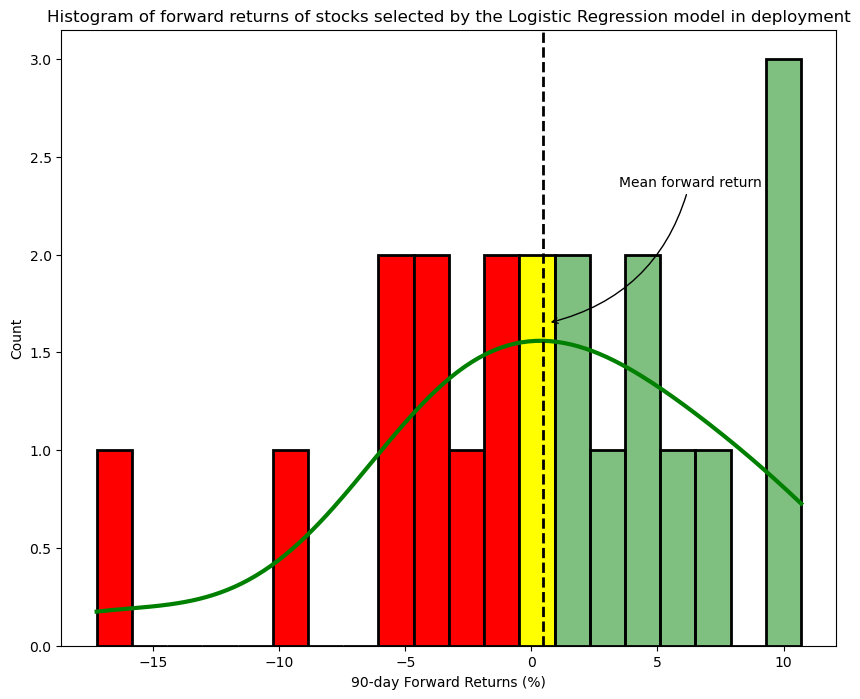

In [110]:
plt.figure(figsize=(10,8))

ax = sns.histplot(update_predicted_returns, kde=True, bins=20, color='green', linewidth=2, line_kws={'lw': 3})
ax.axvline(update_predicted_returns.mean(), color='black', linestyle='--', linewidth=2)
ax.annotate(
    'Mean forward return', xy=(update_predicted_returns.mean()+0.2, ax.get_ylim()[1]-1.5), xytext=(update_predicted_returns.mean()+3, ax.get_ylim()[1]-1 * 0.8),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.3', color='black')
)

for patch in ax.patches:
    if patch.get_x() < 0:
        patch.set_facecolor('yellow')
    if patch.get_x() < -1:
        patch.set_facecolor('red')

ax.set_title('Histogram of forward returns of stocks selected by the Logistic Regression model in deployment')
ax.set_xlabel('90-day Forward Returns (%)')

plt.show()

In [111]:
update_pos_pred_stocks = update_combined_df[update_preds == 1]
update_pos_pred_stocks

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,Fwd rets,1,11,...,31,41,51,61,71,81,91,101,mean_price,median_price
G,0.03,45.07,45.94,42.06,48.85,22.92,12.00,1.51,0.00,0.14,...,-6.70,-8.71,-7.92,-1.26,-5.09,-7.57,-7.57,-4.72,-5.13,-5.27
WNS,0.03,83.15,84.68,75.50,89.16,22.08,12.00,9.99,0.00,2.45,...,-2.78,-6.44,-2.64,-1.69,-2.33,-1.78,-4.91,-7.54,-2.72,-2.64
CZNC,0.02,23.85,24.33,22.67,25.77,25.79,13.00,-0.67,0.00,4.50,...,-2.15,2.31,-0.78,2.39,0.87,0.33,-0.83,-3.71,-0.41,-0.45
TCBI,0.04,58.32,59.98,54.44,65.74,34.22,12.00,-17.25,0.00,9.62,...,5.27,0.68,9.01,-2.10,4.64,0.88,-2.71,-1.51,1.47,0.97
AVD,0.04,22.30,22.71,19.62,24.13,22.20,12.00,-10.04,0.00,-3.75,...,-5.62,-6.95,-1.32,-6.22,-9.25,-11.08,-10.44,-5.24,-6.58,-6.22
CACI,0.03,297.93,303.47,275.79,319.33,26.01,14.00,4.92,0.00,-4.36,...,0.58,-0.77,-3.09,-0.32,-0.36,-3.28,-6.13,-3.38,-1.65,-1.23
EDR,0.04,21.29,22.12,19.64,24.40,50.40,13.00,0.00,0.00,1.23,...,-2.19,-0.14,-2.55,0.41,-1.87,1.59,6.51,4.33,-0.33,-0.59
HQL,0.03,14.72,14.86,13.29,15.30,11.62,12.00,-5.16,0.00,2.45,...,1.84,-2.45,0.48,0.34,-0.34,-4.97,-5.72,-7.35,-1.49,-0.54
SPLP,0.02,42.29,43.46,38.00,46.13,44.27,16.00,3.41,0.00,0.00,...,-1.18,0.47,2.26,3.84,1.29,5.18,2.35,1.18,1.20,1.18
UTL,0.03,51.26,52.25,48.77,56.74,27.19,14.00,-0.94,0.00,-5.05,...,-5.63,-5.34,-2.99,-6.98,-5.69,-1.02,-1.66,1.55,-3.81,-4.52


The returns in the deployment test are less stellar. A significant portion of the downside is from a single stock (TCBI) - which gapped down badly after missing earnings at the end of March 2023, hence the 17% loss taken there. 

However, there's still a slight net gain of ~0.5%, so I wouldn't call this a crushing defeat by any means. 

### 6. Deployment 

In [112]:
def predict_stocks(deployment_test_dates, model):
    
    def acquire_data(deployment_test_dates):
        deployment_var_df, deployment_back_df, deployment_fwd_df, deployment_price_df = list_of_returns_calc(
            small_cap_price_data, 0.1, deployment_test_dates, 150, 90
        )

        deployment_combined_df = pd.concat([deployment_var_df.T, deployment_back_df.T, 
                                           deployment_fwd_df.T, deployment_price_df.T], axis=1)

        price_cols = deployment_combined_df.loc[:,1:]

        # add mean price feature
        mean_prices = price_cols.mean(axis=1)
        deployment_combined_df['mean_price'] = mean_prices

        # add median price feature
        median_prices = price_cols.median(axis=1)
        deployment_combined_df['median_price'] = median_prices
        
        return deployment_combined_df
    
    def clean_data(deployment_combined_df):
        # drop cols not multiples of 10
        keep_cols = np.arange(1,106,10)
        all_cols = np.arange(1,106)
        drop_cols = np.setdiff1d(all_cols, keep_cols)
        cleaned_df = deployment_combined_df.drop(columns=drop_cols, errors='ignore')

        cleaned_df.columns = cleaned_df.columns.astype(str)
        cleaned_df.dropna(axis=0, inplace=True)
        
        return cleaned_df
    
    deployment_combined_df = acquire_data(deployment_test_dates)
    cleaned_df = clean_data(deployment_combined_df)
    X = cleaned_df.drop(columns=['Fwd rets'])

    return X[model.predict(X)==1]

In [113]:
a = predict_stocks(['2023-06-30'], best_logreg_pipe)
a

,Var,buy_price,sell_price,min_low,max_high,backtest_returns,num_buys_sells,1,11,21,31,41,51,61,71,81,91,101,mean_price,median_price
MMD,0.02,17.11,17.28,16.41,18.09,14.26,14.00,0.00,0.00,-2.42,-0.90,-4.50,-3.43,-2.92,-4.44,-4.89,-1.74,-4.56,-3.20,-3.35
OXY,0.04,58.90,60.03,55.51,66.99,23.02,12.00,0.00,2.39,-7.84,-12.33,-4.17,-0.03,-6.50,-10.59,-9.23,-8.44,-11.64,-6.71,-7.84
SJW,0.03,75.15,76.54,68.23,81.86,27.64,15.00,0.00,-0.63,-3.97,-1.36,-1.90,3.22,-0.54,-1.59,-3.38,-2.56,-10.39,-1.83,-1.63
TRNO,0.03,61.08,62.23,56.48,67.03,20.71,11.00,0.00,-0.26,-4.33,-3.23,-2.17,-2.08,-5.11,-3.65,-7.84,-9.05,-9.90,-4.00,-3.76
CHCO,0.04,89.21,91.72,82.53,100.77,30.89,11.00,0.00,4.10,2.70,-2.38,-3.96,-3.20,-4.91,-11.84,-6.71,1.59,-3.81,-2.06,-3.09
ESTA,0.04,66.89,69.43,62.45,79.88,53.12,14.00,0.00,5.91,7.22,-0.04,-1.53,10.38,0.59,3.06,-4.63,0.78,-5.51,1.80,1.25
GAIN,0.03,12.90,13.03,12.11,14.55,13.18,13.00,0.00,2.87,2.28,-4.26,-3.01,-0.22,-0.15,-5.37,-5.88,-5.37,-6.76,-2.10,-2.98
JGGC,0.01,10.54,10.88,10.31,11.68,45.07,14.00,0.00,-0.12,0.37,0.37,0.75,0.75,6.12,1.43,1.43,1.91,2.30,0.99,0.75
LANDM,0.01,23.51,23.75,22.57,24.45,14.04,14.00,0.00,-0.66,-1.47,-1.78,-1.90,-2.15,-1.12,-1.70,-3.11,-1.57,-1.86,-1.54,-1.59
NRC,0.03,44.39,45.21,39.89,47.60,27.64,15.00,0.00,-4.59,-3.60,-6.85,-3.60,-2.87,-5.45,-7.04,-6.33,-3.06,-4.72,-4.46,-4.10


In [114]:
import joblib
with open("stock_predictor.joblib", "wb") as f:
    joblib.dump(best_logreg_pipe, f)